In [2]:
import numpy as np
import cvxpy as cp

In [39]:
# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cp.Minimize((x - y)**2)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
print("is_dcp", prob.is_dcp())
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

is_dcp True
status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


In [345]:
params = {}
params["lambda"] = 1
params["alpha"] = 0.5
params["gamma"] = 0.2


### Generating Dataset

In [413]:
n = 10;
p = 1;
X = np.random.random((n, p))
Beta_true = np.random.normal(size=(p))
y = np.random.normal(np.matmul(X, Beta_true), 0.05/np.sqrt(n))

In [414]:
Beta_true

array([1.00268675])

In [415]:
import matplotlib.pyplot as plt

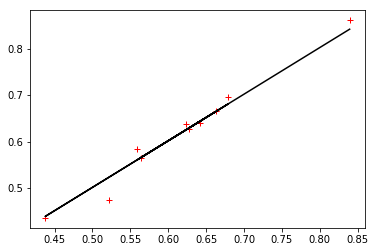

In [416]:
plt.plot(X[:, 0], y, "r+")
plt.plot(X[:, 0], np.matmul(X, Beta_true), "k-")

## Optimization

In [417]:
def penalty(z):
    return params["lambda"]*((1-params["alpha"])/2*np.linalg.norm(z, 1) + params["alpha"]*np.linalg.norm(z, 2))

In [418]:
A = 1/np.sqrt(n)*X
c = -1/n*X.T @ y
#print(c.shape)
def lagrangian(beta, xi, z, gamma=params["gamma"]):
    #print(beta.sign, beta.curvature)
    
    first = 1/2*cp.norm(A @ beta, 2) 
    third = 1/2*gamma*cp.norm(beta - z, 2) ## diminue si beta = z
    second = (c - xi).T @ beta ## diminue si beta augmente
    #print(first, second, third, fourth)
    #return first.squeeze() + second.squeeze() + third.squeeze() + fourth.squeeze() + penalty(z).squeeze()
    return first + second + third + penalty(z)


In [419]:
def soft_thres(a, b):
    return -((np.abs(b) < a)*((a>0)*(a-b)+(a<=0)*(a+b)))

In [420]:
def optimal_z(beta, xi, 
              alpha=params["alpha"], 
              lambd=params["lambda"], 
              gamma=params["gamma"]):
    return soft_thres(xi-gamma*beta, lambd*alpha)/((1-alpha)*lambd+gamma)

In [421]:
## Algo
block_size = 1
def one_cycle_racmbadmm(p, beta, xi0, z0):
    num_blocks = p // block_size
    # Split in blocks
    permutation = list(range(p))
    np.random.shuffle(permutation)
    
    # Optimize beta
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        print("indexes", indexes)
        mask = np.diag([int(i in indexes) for i in range(p)])
        #print(mask)
        beta_vr = cp.Variable(p)
        beta_mask = mask*beta_vr
        #print(beta_mask)
        obj = cp.Minimize(lagrangian(beta_mask, xi0, z0))
        prob = cp.Problem(obj, [])
        print(prob.is_dcp())
        print(prob.solve())
        print(prob.status)
        beta[indexes] = beta_vr.value[indexes]
    # Optimal
    z = optimal_z(beta, xi0)
    # Optimize xi
    xi = xi0 - params["gamma"]*(beta - z)
    
    return beta, xi, z

In [422]:
lagrangian(Beta_true, 0, Beta_true).value

0.6715809468672267

In [423]:
beta0 = np.random.random(size=p)
z0 = np.random.random(size=p)
xi0 = np.random.random(size=p)

In [424]:
print((c - xi0 - params["gamma"]*z0))

[-0.91609103]


In [425]:
beta0, xi0, z0 = one_cycle_racmbadmm(p, beta0, xi0, z0)

indexes [0]
True
-inf
unbounded


TypeError: 'NoneType' object is not subscriptable

In [426]:
print(Beta_true, beta0, z0)

[1.00268675] [0.79912144] [0.80298961]


In [410]:
penalty(z0)

0.5941643094927811

In [411]:
lagrangian(beta0, xi0, z0).value

0.37268233423372665

In [412]:
xi0

array([0.24242712])